In [1]:
import sys

sys.path.append("../")

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import numpy

from main import *

np.random.seed(0)

An application of our framework is the preparation of target eigenstates of a given Hamiltonian. In this notebook we show an example of this, preparing an eigenvector of the Hamiltonian
$$H = P^2 -a X^3 -bX.$$
This Hamiltonian permits the preparation of quantum states whose Wigner function is concentrated on the trajectory of the elliptic curve
$$ y^2 = ax^x+bx+c .$$
with $c=\langle H \rangle$. Cryptography based on elliptic curves is one of the standard protocols for cybersecurity, and loading elliptic curves in quantum computers could be used to break their security with the Shor algorithm. Let us define an elliptic curve:

(-8.0, 8.0)

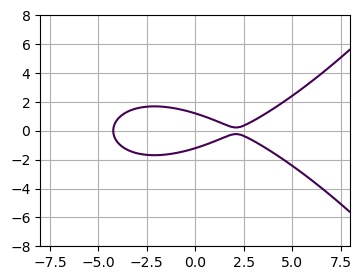

In [3]:
a = 0.075
b = -1
c = 1.4575131
m = 1 / 2

y, x = numpy.ogrid[-8:8:100j, -8:8:100j]
plt.figure(figsize=(4, 3))
plt.contour(x.ravel(), y.ravel(), y**2 - a * x**3 - b * x - c, [0])
plt.grid()
plt.xlim(-8, 8)
plt.ylim(-8, 8)

Defining the Hamiltonian. Given that $X$ and $X^3$ are complatibles, we merge them in a single operator by the function ```addition```. 

In [4]:
num_qubits = 6

X, P = X_and_P_ops(range(num_qubits), x_min=-8, x_max=8)

Hamil = [
    qml.s_prod(0.5 / m, P.pow(2)),
    addition(qml.s_prod(-a, X.pow(3)), qml.s_prod(-b, X.pow(1))),
]

Calculating the analytical eigenstates with numpy.

In [5]:
H_matrix = (0.5 / m) * P.pow(2).matrix() + addition(
    qml.s_prod(-a, X.pow(3)), qml.s_prod(-b, X.pow(1))
).matrix()

vals, vecs = np.linalg.eigh(H_matrix)
idx_target = np.argmin(np.abs(vals - c))
val = vals[idx_target]
vec = vecs[:, idx_target]
val, c, vals

(1.5144953668009487,
 1.4575131,
 array([-21.47347295, -13.13889991,  -7.27227074,  -2.92320837,
         -0.73603537,   0.17723996,   0.51848972,   1.51449537,
          2.10603082,   2.92062032,   3.8762867 ,   4.91593705,
          6.03747745,   7.23197927,   8.49159951,   9.81414382,
         11.18962672,  12.6267247 ,  14.09838813,  15.64842281,
         17.18833613,  18.87072908,  20.42899281,  22.30014173,
         23.80144911,  25.95934982,  27.33741411,  29.88159727,
         31.12548032,  34.09634532,  35.23993922,  38.61875535,
         39.70233089,  43.45224555,  44.5068774 ,  48.59516992,
         49.64369507,  54.04458114,  55.10533203,  59.7974561 ,
         60.88712523,  65.85089044,  66.98659038,  72.20197214,
         73.40301686,  78.84756813,  80.13742799,  85.78412706,
         87.19297625,  93.0076938 ,  94.57598881, 100.51477664,
        102.29819007, 108.30595533, 110.38123027, 116.39662258,
        118.86577816, 124.84271346, 127.8278831 , 133.78868638,
       

Unfortunately, we were not able to find a suitable variational circuit for this problem. Due to that, for simplicity, we optimize over arbitrary pure states.

In [6]:
def init_state():
    pass

In [7]:
num_layers = 1
var_state_class = arbitrary_state(num_qubits, num_layers)
var_state = var_state_class.construct_circuit

num_params = var_state_class.num_params
num_params

64

(<Figure size 400x700 with 1 Axes>, <Axes: >)

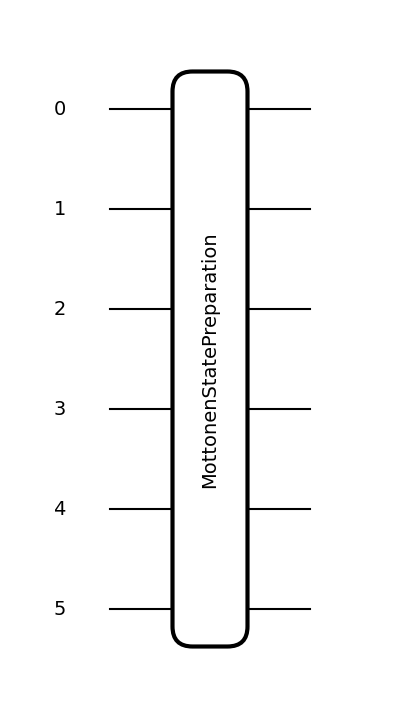

In [8]:
qml.draw_mpl(var_state)(num_params * [1])

Defining the device and the solver. We include the target energy $c$ on the solver in order ot minimize the error
$$ f(\psi) = ( c - \langle \psi | H | \psi \rangle )^2.$$
This ensure that the optimization drives the variational state $| \psi \rangle$ to the eigenstate with energy c.

In [9]:
device = qml.device("lightning.qubit", wires=num_qubits)

varqft = VarFourier(
    Hamil, device, var_state=var_state, init_state=init_state, target_energy=c
)

We renormalize the parameters after each iteration to ensure it is a valid state. In this case, since we are optimizing an error function, the target energy is $0$. Lets run the simulation,

In [10]:
params_init = vec + 1e-2 * np.random.randn(num_params)
params_init = params_init / np.linalg.norm(params_init)
varqft.energy_eval(params_init)

params_ground, energies_ground = varqft.run(
    params_init,
    learning_rate=1e-3,
    postprocessing=lambda x: x / np.linalg.norm(x),
    conv_tol=1e-7,
)

Step:    130, Energy:     0.000001


In [11]:
np.min(energies_ground)

5.563016177019148e-09

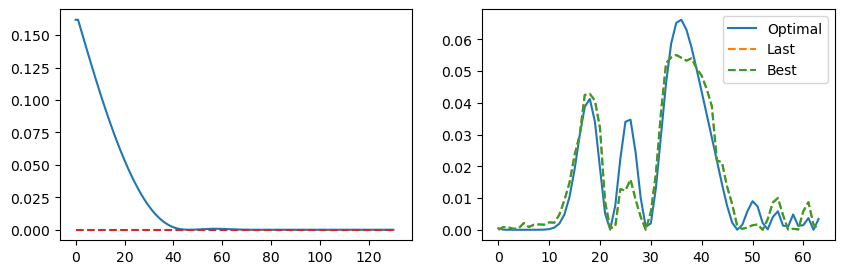

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

ax[0].plot(energies_ground)
ax[0].hlines(0, 0, len(energies_ground), colors="tab:red", linestyles="--")

ground_state = varqft.state(params_ground[np.argmin(energies_ground)])
last_state = varqft.state(params_ground[-1])

ax[1].plot(np.abs(vec) ** 2)
ax[1].plot(np.abs(last_state) ** 2, "--")
ax[1].plot(np.abs(ground_state) ** 2, "--")
ax[1].legend(["Optimal", "Last", "Best"])

We obtain a solution with the following fidelity:

In [13]:
fid = np.abs(vecs.T.conj() @ ground_state) ** 2
fid[idx_target]

tensor(0.92417714, requires_grad=True)

The elliptic curve can be seen in the Wigner function associated with the ground state.

In [14]:
def Wigner(rho):
    d = len(rho)
    W = np.zeros((d, d), dtype=complex)
    for m in range(d):
        for mu in range(d):
            for n in range(d):
                W[m, mu] += (
                    np.exp(4j * np.pi * n * mu / d) * rho[(m - n) % d, (m + n) % d] / d
                )
    return W

In [15]:
W = Wigner(np.outer(ground_state, ground_state.conj()))

In [16]:
def plot_wigner(W, X, P):

    W = np.copy(W)
    plt.figure(figsize=(4, 3))
    plt.imshow(
        W.real.T,
        extent=[
            X.eigvals().min(),
            X.eigvals().max(),
            P.eigvals().min(),
            P.eigvals().max(),
        ],
        cmap="RdBu",
        interpolation="nearest",
        origin="lower",
        aspect="auto",
        vmin=-np.max(np.abs(W)),
        vmax=np.max(np.abs(W)),
    )
    plt.colorbar()
    plt.xlim(-5, 5)
    plt.ylim(-5, 5)
    y, x = numpy.ogrid[-8:8:100j, -8:8:100j]
    plt.contour(x.ravel(), y.ravel(), y**2 - a * x**3 - b * x - c, [0], colors="black")

The positive part of the Wigner function is concentrated over the classical trajectory of the elliptic curve! 

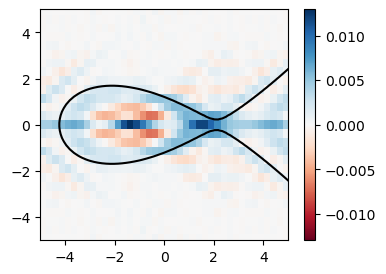

In [17]:
plot_wigner(W, X, P)